In [1]:
!python --version

#### Installing used libs

In [2]:
!pip install -U tensortrade==1.0.3 ta matplotlib tensorboardX scikit-learn

#### Checking if installed version of Tensortrade is the version 1.0.3

In [3]:
import tensortrade
print(tensortrade.__version__)

1.0.3


#### Importing used libs

In [4]:
import random

import ta
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensortrade.env.default as default
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import A2CAgent
import tensortrade.stochastic as sp 

from tensortrade.env.default.actions import SimpleOrders, BSH, ManagedRiskOrders
from collections import OrderedDict
from tensortrade.oms.orders.criteria import Stop, StopDirection
from tensortrade.env.default.actions import ManagedRiskOrders
from tensortrade.env.default.rewards import RiskAdjustedReturns

#### Helper functions used to generate technical analysis features and create the environment for agent training and testing

In [5]:
def fetchTaFeatures(data, columns = {'open': "open", 'high':"high", 'low':"low", 'close':"close", 'volume':"volume"}, 
                   colprefix=""):
    data = ta.add_all_ta_features(data, columns['open'], columns['high'], columns['low'], columns['close'], 
                                  columns['volume'], colprefix=colprefix, fillna=True)
    data.columns = [name.lower() for name in data.columns]
    return data

def createEnv(config):

    with NameSpace("bitfinex"):
        bitfinex_streams = [
            Stream.source(list(config["data"][c]), dtype="float").rename(c) for c in config["data"].columns
        ]

    feed = DataFeed(bitfinex_streams)


    p = Stream.source(list(config["data"]["close"]), dtype="float").rename("USD-BTC")

    bitstamp = Exchange("bitfinex", service=execute_order)(
        p
    )
    
    cash = Wallet(bitstamp, 10000 * USD)
    asset = Wallet(bitstamp, 0 * BTC)

    portfolio = Portfolio(USD, [cash, asset
        
    ])
    
    reward = RiskAdjustedReturns(return_algorithm = "sortino", window_size=3000)
    action_scheme = ManagedRiskOrders(stop=[0.1], take=[0.05, 0.1, 0.04, 0.02], trade_sizes=[20])
    
    env = default.create(
      feed=feed,
      portfolio=portfolio,
      action_scheme=action_scheme,
      reward_scheme=reward,
      window_size=config["window_size"]
    )
    
    return env


#### Creating data with stochastic process for training

<AxesSubplot:>

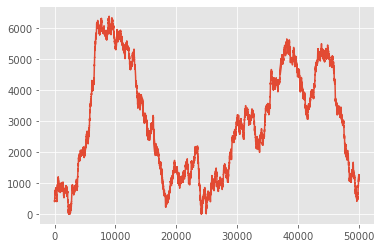

In [102]:
# from scipy.signal import savgol_filter
# funcs = [sp.gbm, sp.heston]

# data = sp.fbm(
    
#     base_price=random.randint(20, 2000),
#     base_volume=random.randint(40, 5000),
#     start_date="2010-01-01",
#     times_to_generate=50000,
#     time_frame='1H')

# for column in ["close", "open", "high", "low", "volume"]:
#     data[f"diff_{column}"] = data[f"{column}"].apply(np.log).diff().dropna()
#     data[f"soft_{column}"] = savgol_filter(data[column], 35, 2)


# data.to_csv("fake_data.csv", index=False)
data = pd.read_csv("fake_data.csv")

data.close.plot()



In [103]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'diff_close', 'soft_close',
       'diff_open', 'soft_open', 'diff_high', 'soft_high', 'diff_low',
       'soft_low', 'diff_volume', 'soft_volume'],
      dtype='object')

#### Adding technical analysis features to the dataframe

In [104]:
data = fetchTaFeatures(data)
data = fetchTaFeatures(data,
                       columns = {'open': "soft_open", 'high':"soft_high", 'low':"soft_low", 
                                  'close':"soft_close", 'volume':"volume"}, 
                       colprefix="soft_"
                      )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



KeyboardInterrupt: 

In [120]:
data

,open,high,low,close,volume,diff_close,soft_close,diff_open,soft_open,diff_high,...,soft_trend_kst_diff,soft_trend_ichimoku_conv,soft_trend_ichimoku_base,soft_trend_ichimoku_a,soft_trend_ichimoku_b,soft_trend_visual_ichimoku_a,soft_trend_visual_ichimoku_b,soft_trend_aroon_up,soft_trend_aroon_down,soft_trend_aroon_ind
0,404.000000,421.499157,402.795040,420.019800,184726.860192,NaN,445.443162,NaN,441.091899,NaN,...,0.000000,442.308376,442.308376,442.308376,442.308376,2959.132019,2958.705208,4.0,4.0,0.0
1,421.325394,435.436550,421.325394,424.409465,184843.917852,0.010397,439.156348,0.041991,435.627638,0.032531,...,-0.531106,439.417689,439.417689,439.417689,439.417689,2959.132019,2958.705208,4.0,8.0,-4.0
2,425.063246,425.063246,414.313500,421.258139,184583.836810,-0.007453,433.361399,0.008833,430.586195,-0.024111,...,-1.025277,436.751903,436.751903,436.751903,436.751903,2959.132019,2958.705208,4.0,12.0,-8.0
3,421.070109,421.070109,405.141255,409.374446,184918.336958,-0.028616,428.058313,-0.009439,425.967569,-0.009439,...,-1.482512,434.311020,434.311020,434.311020,434.311020,2959.132019,2958.705208,4.0,16.0,-12.0
4,408.629726,414.614130,401.226524,411.324441,184861.280540,0.004752,423.247092,-0.029990,421.771761,-0.015451,...,-1.902812,432.095038,432.095038,432.095038,432.095038,2959.132019,2958.705208,4.0,20.0,-16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1196.260531,1202.818168,1190.562239,1198.554444,187927.915848,0.001815,1191.192097,-0.001027,1197.494371,0.004440,...,-26.016722,1217.336000,1222.322194,1219.829097,1180.273020,1173.459051,1079.511605,48.0,100.0,-52.0
49996,1197.109298,1197.109298,1187.970426,1190.124270,176720.068793,-0.007058,1182.510957,0.000709,1189.524674,-0.004758,...,-27.599513,1211.386144,1218.220795,1214.803470,1181.488923,1177.437573,1084.109045,44.0,100.0,-56.0
49997,1190.705475,1192.735150,1165.600857,1165.973959,184662.867652,-0.020501,1173.242192,-0.005364,1180.992150,-0.003661,...,-29.048708,1204.868326,1213.835176,1209.351751,1182.594027,1181.812209,1089.440951,40.0,100.0,-60.0
49998,1166.710967,1177.609657,1160.903359,1164.064397,194111.124499,-0.001639,1163.385803,-0.020357,1171.896799,-0.012762,...,-30.364316,1197.782548,1209.165335,1203.473941,1183.569842,1186.379283,1095.364462,36.0,100.0,-64.0


In [ ]:
# data.columns

#### Normalizing the data

In [106]:
scaler = MinMaxScaler(feature_range=(0.1, 1.1))
norm_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
norm_data.to_csv("fake_data_norm.csv", index=False)
import joblib
joblib.dump(scaler, 'scaler.save')

# norm_data = pd.read_csv("fake_data_norm.csv")


['scaler.save']

In [107]:
norm_data

,open,high,low,close,volume,diff_close,soft_close,diff_open,soft_open,diff_high,...,soft_trend_kst_diff,soft_trend_ichimoku_conv,soft_trend_ichimoku_base,soft_trend_ichimoku_a,soft_trend_ichimoku_b,soft_trend_visual_ichimoku_a,soft_trend_visual_ichimoku_b,soft_trend_aroon_up,soft_trend_aroon_down,soft_trend_aroon_ind
0,0.163329,0.165396,0.163249,0.165861,0.239165,NaN,0.168478,NaN,0.167807,NaN,...,0.511407,0.167682,0.165829,0.166301,0.164701,0.564677,0.564541,0.100000,0.100000,0.600000
1,0.166047,0.167582,0.166159,0.166550,0.239542,0.535249,0.167486,0.591777,0.166946,0.568485,...,0.511089,0.167226,0.165371,0.165844,0.164242,0.564677,0.564541,0.100000,0.141667,0.579167
2,0.166634,0.165955,0.165058,0.166056,0.238704,0.533162,0.166572,0.587412,0.166151,0.551628,...,0.510793,0.166805,0.164949,0.165422,0.163818,0.564677,0.564541,0.100000,0.183333,0.558333
3,0.166007,0.165329,0.163618,0.164192,0.239782,0.530688,0.165736,0.585006,0.165422,0.555994,...,0.510519,0.166420,0.164562,0.165035,0.163431,0.564677,0.564541,0.100000,0.225000,0.537500
4,0.164055,0.164316,0.163003,0.164497,0.239598,0.534589,0.164977,0.582301,0.164761,0.554205,...,0.510267,0.166070,0.164211,0.164685,0.163078,0.564677,0.564541,0.100000,0.266667,0.516667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.287638,0.287944,0.286953,0.287980,0.249488,0.534246,0.286085,0.586114,0.287090,0.560125,...,0.495818,0.289978,0.289363,0.289371,0.281959,0.282031,0.265949,0.558333,1.100000,0.329167
49996,0.287771,0.287049,0.286546,0.286657,0.213343,0.533209,0.284715,0.586342,0.285833,0.557388,...,0.494870,0.289039,0.288713,0.288576,0.282152,0.282661,0.266679,0.516667,1.100000,0.308333
49997,0.286766,0.286363,0.283033,0.282869,0.238958,0.531637,0.283254,0.585543,0.284487,0.557714,...,0.494002,0.288011,0.288019,0.287713,0.282328,0.283354,0.267527,0.475000,1.100000,0.287500
49998,0.283001,0.283990,0.282295,0.282570,0.269429,0.533842,0.281699,0.583569,0.283053,0.555005,...,0.493214,0.286892,0.287279,0.286782,0.282483,0.284076,0.268468,0.433333,1.100000,0.266667


#### Creating a training environment with a 10-period window

In [108]:
config = {
            "window_size": 10,
            "data": norm_data
        }

env = createEnv(config)

#### Running agent training with 100,000 steps and 10 episodes.
The agent will be saved in the "agents/" folder

In [109]:
!mkdir -p agents/

agent = A2CAgent(env)
reward = agent.train(n_steps=20000, save_path="agents/", n_episodes = 10)

====      AGENT ID: 09cbaebf-2910-41d6-aa8c-8a2fbff0e019      ====
====      EPISODE ID (1/10): b4ffa8a9-f54e-495c-9492-5896550ac091      ====


#### Creating a new environment to check agent performance in training

In [110]:
env = createEnv({
    "window_size": 10, 
    "data": norm_data
})


#### Require action until step returns Done == True

In [111]:
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.get_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

In [112]:
reward

1.0

#### Plotting agent performance

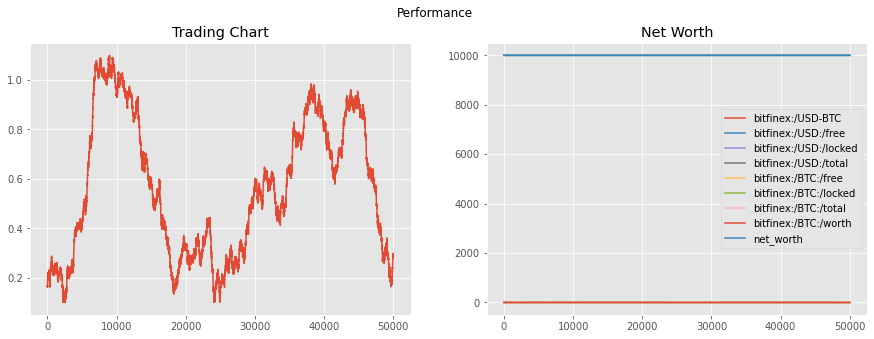

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("Performance")

axs[0].plot(np.arange(len(norm_data["close"])), norm_data["close"], label="price")
axs[0].set_title("Trading Chart")

performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
performance_df.plot(ax=axs[1])
axs[1].set_title("Net Worth")

plt.show()

In [114]:
orDict = OrderedDict()
for k in env.action_scheme.portfolio.performance.keys():
    orDict[k] = env.action_scheme.portfolio.performance[k]["net_worth"]

<AxesSubplot:>

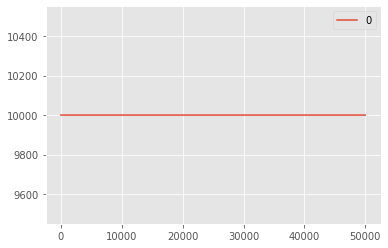

In [115]:
pd.DataFrame().from_dict(orDict, orient='index').plot()

#### Create new data to assess how the agent behaves in data you've never seen

<AxesSubplot:>

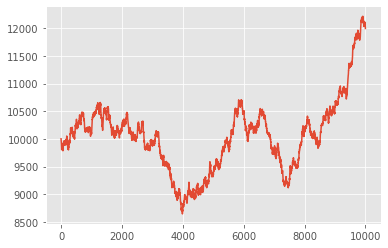

In [116]:
data2 = sp.fbm(
    base_price=10000,
    base_volume=5000,
    start_date="2010-01-01",
    times_to_generate=10000,
    time_frame='1H'
)
data2 = data2.reset_index(drop=True)
data2.close.plot()


In [117]:
for column in ["close", "open", "high", "low", "volume"]:
    data2[f"diff_{column}"] = data2[f"{column}"].apply(np.log).diff().dropna()
    data2[f"soft_{column}"] = savgol_filter(data2[column], 35, 2)


In [118]:
data2 = fetchTaFeatures(data2)
data2 = fetchTaFeatures(data2,
                       columns = {'open': "soft_open", 'high':"soft_high", 'low':"soft_low", 
                                  'close':"soft_close", 'volume':"volume"}, 
                       colprefix="soft_"
                      )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



In [119]:
norm_data = pd.DataFrame(scaler.transform(data2), columns=data2.columns)

ValueError: X has 181 features, but MinMaxScaler is expecting 158 features as input.

In [ ]:
env = createEnv({
    "window_size": 10, 
    "data": norm_data
})

episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.get_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

#### Ploting performance in test data

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("Performance")

axs[0].plot(np.arange(len(data2["close"])), data2["close"], label="price")
axs[0].set_title("Trading Chart")

performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
performance_df.plot(ax=axs[1])
axs[1].set_title("Net Worth")
# axs[1].set_xlim(0, 800)

plt.show()